# Process 'Student Internships | Skills Wish Learned' Question Using a LLM

A generic version of the pipeline to be re-used for different types of questions.

Andrew Weng, 1/1/2025

We are going to use a mixed LLM-Python approach to solve the problem of "user text categorization."

This problem can be decomposed into five steps:

1. Pre-process (LLM1)
 - Each user provides up to three keywords as a string. These keywords need to be normalized and stored in a large list of individual keywords for the next stage.
2. Define categories (LLM2)
 - With the list of keywords, find the best set of categories to describe the keywords
3. Assign categories (LLM3)
 - For each keyword, assign it to a category. Be careful about how to handle exceptions (e.g., a keyword that doesn't seem to belog into any particular category.)
4. Count occurences (Python)
 - Within each category, sum up the total number of keywords. 
5. Visualize the results (Python)

In [1]:
import os
import time

current_folder = os.path.basename(os.getcwd())
if current_folder == 'notebooks':
    root_path = os.path.dirname(os.path.abspath(''))
    os.chdir(root_path)

from src.analyst import Analyst
from src.plotter import Plotter
from src.llm import LLM

from collections import defaultdict

import pickle
from pprint import pprint

from IPython import get_ipython
# Automatically reload all modules every time a line of code is executed
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')

# Initialize our helper classes

In [2]:
analyst = Analyst()
analyst.load_data()
analyst.build_respondents_list()

plotter = Plotter()
llm = LLM()

# Fetch the relevant dataset to analyze

In [3]:
question = dict()
question['tag']= 'student_internship_skills_wish_learned'
question['question'] = "During your previous internship, were there skills you wish you had learned but didn't? If yes, what were they?"
question['categories'] = [
    'Supply Chain Management',
    'Quality Control / Quality Standards',
    'Statistics / Statistical Analysis',
    'Project Management / Program Management / Project Planning',
    'Communication / Collaboration / Networking / Professional Development / '
    'Leadership / Negotiation',
    'Industry Knowledge',
    'Programming / Software Skills',
    'Battery Chemistry / Electrochemistry / Material Science / Synthesis',
    'Simulation / Modelling / Computational Materials Discovery / Battery Pack '
    'Modelling / CFD Modeling',
    'Control Systems / Kalman Filtering / PLC',
    'Battery Management Systems (BMS)',
    'Mechanical Engineering / Battery Pack Design / Integration',
    'Testing Methods / Coin Cell Production',
    'Data Analysis / Machine Learning / Artificial Intelligence',
    'Engineering Skills / Advanced Technical Skills / Basic Design',
    'HVAC / Thermal Engineering',
    'Battery Electronics / Electrical Engineering',
    'Manufacturing / Process Engineering',
    'Proposal Writing',
    'E-mobility'
 ]
question['data'] = analyst.summarize_student_internship()['internship_skills_wish_learned_list']

In [4]:
question['data']

['Supply chain',
 'Quality control, statistics,',
 'Knowledge about subjects out of academy',
 'Project planning',
 'New material evaluation; Pack design;',
 '"Good communications with industry needs"',
 'HVAC (deeper understanding), GT Suite, Kalman Filtering implementation, Production Codes',
 'Electrochemistry; Coding; Material Science',
 'Simulink; GT-Suite/Simulation SW',
 'Computational Materials Discovery;',
 'Industry knowledge; simulation methods; BMS',
 'matlab, python',
 'Programming languege',
 'In depth EIS studies, in-depth xps studies',
 'manufacturing',
 'coin cell production',
 'Program management, Pack-level knowledge',
 'Module/Pack integration, BMS, GITT',
 'More on controls',
 'ML',
 'coding',
 'Process Engineering, Battery Integration, Engineering Skills',
 'networking, large data analyses, mechanical engineering',
 'Collaboration, Testing Methods, Modelling',
 'battery management system, cfd modeling,',
 'Yes, battery electronics',
 'Battery management system, ce

# Pre-process the user response

Interpret the delimiters

In [5]:
keyword_list = []

for i, string_of_list in enumerate(question['data']):
    print(f"Processing response {i+1} of {len(question['data'])}")
    list_of_strings = llm.delimit_string_of_list(string_of_list)
    print(f'--> {list_of_strings}\n')
    keyword_list.extend(list_of_strings)

# Assemble and cache the list
print(keyword_list)
timestamp = time.strftime('%Y%m%d_%H%M%S')
with open(f'data/strlist_{question['tag']}_{timestamp}.pkl', 'wb') as f:
    pickle.dump(keyword_list, f)

Processing response 1 of 39
--> ['Supply chain']

Processing response 2 of 39
--> ['Quality control', 'statistics']

Processing response 3 of 39
--> ['Knowledge about subjects out of academy']

Processing response 4 of 39
--> ['Project planning']

Processing response 5 of 39
--> ['New material evaluation', 'Pack design']

Processing response 6 of 39
--> ['Good communications', 'industry needs']

Processing response 7 of 39
--> ['HVAC (deeper understanding)', 'GT Suite', 'Kalman Filtering implementation']

Processing response 8 of 39
--> ['Electrochemistry', 'Coding', 'Material Science']

Processing response 9 of 39
--> ['Simulink', 'GT-Suite/Simulation SW']

Processing response 10 of 39
--> ['Computational Materials Discovery']

Processing response 11 of 39
--> ['Industry knowledge', 'simulation methods', 'BMS']

Processing response 12 of 39
--> ['matlab', 'python']

Processing response 13 of 39
--> ['Programming languege']

Processing response 14 of 39
--> ['EIS studies', 'in-depth xp

# Define categories

In [7]:
if question['categories'] == []:

    categories = llm.define_categories(question['question'],
                                       keyword_list,
                                       num_categories=50)

    category_list = []
    for category in categories['categories']:
        category_list.append(category['name'])

else:
    category_list = question['categories']

pprint(category_list)

['Supply Chain Management',
 'Quality Control / Quality Standards',
 'Statistics / Statistical Analysis',
 'Project Management / Program Management / Project Planning',
 'Communication / Collaboration / Networking / Professional Development / '
 'Leadership / Negotiation',
 'Industry Knowledge',
 'Programming / Software Skills',
 'Battery Chemistry / Electrochemistry / Material Science / Synthesis',
 'Simulation / Modelling / Computational Materials Discovery / Battery Pack '
 'Modelling / CFD Modeling',
 'Control Systems / Kalman Filtering / PLC',
 'Battery Management Systems (BMS)',
 'Mechanical Engineering / Battery Pack Design / Integration',
 'Testing Methods / Coin Cell Production',
 'Data Analysis / Machine Learning / Artificial Intelligence',
 'Engineering Skills / Advanced Technical Skills / Basic Design',
 'HVAC / Thermal Engineering',
 'Battery Electronics / Electrical Engineering',
 'Manufacturing / Process Engineering',
 'Proposal Writing',
 'E-mobility']


# Assign categories

Process one keyword at a time!

In [8]:
content_list = []
other_list = []
fail_list = []

for i, keyword in enumerate(keyword_list):

    print(f"Processing response: '{keyword}' ({i+1} of {len(keyword_list)})...")

    try:
        output = llm.classify_user_response(category_list, keyword,
                                            model='gpt-4o-mini')
    except: # JSON output fails
        fail_list.append(keyword)
        continue

    if output['result']['category'] in category_list:
        content_list.append(output)
    else:
        other_list.append(output)

Processing response: 'Supply chain' (1 of 74)...
Processing response: 'Quality control' (2 of 74)...
Processing response: 'statistics' (3 of 74)...
Processing response: 'Knowledge about subjects out of academy' (4 of 74)...
Processing response: 'Project planning' (5 of 74)...
Processing response: 'New material evaluation' (6 of 74)...
Processing response: 'Pack design' (7 of 74)...
Processing response: 'Good communications' (8 of 74)...
Processing response: 'industry needs' (9 of 74)...
Processing response: 'HVAC (deeper understanding)' (10 of 74)...
Processing response: 'GT Suite' (11 of 74)...
Processing response: 'Kalman Filtering implementation' (12 of 74)...
Processing response: 'Electrochemistry' (13 of 74)...
Processing response: 'Coding' (14 of 74)...
Processing response: 'Material Science' (15 of 74)...
Processing response: 'Simulink' (16 of 74)...
Processing response: 'GT-Suite/Simulation SW' (17 of 74)...
Processing response: 'Computational Materials Discovery' (18 of 74)...

In [9]:
print(len(other_list))

2


In [10]:
other_list

[{'result': {'response_text': 'Knowledge about subjects out of academy',
   'category': 'Other'}},
 {'result': {'response_text': 'GITT', 'category': 'Other'}}]

In [11]:
print(len(fail_list))

0


## Assembly dictionary for plotting and a 'collection' dictionary

The 'collection' is a reference for which keywords got sorted into which categories.

In [12]:

collection = defaultdict(list)
counter    = defaultdict(int)

for content in content_list:

    category = content['result']['category']
    response = content['result']['response_text']
    counter[category] += 1
    collection[category].append(response)

counter['_tot_'] = len(question['data'])
counter

defaultdict(int,
            {'Supply Chain Management': 1,
             'Quality Control / Quality Standards': 3,
             'Statistics / Statistical Analysis': 2,
             'Project Management / Program Management / Project Planning': 4,
             'Battery Chemistry / Electrochemistry / Material Science / Synthesis': 9,
             'Mechanical Engineering / Battery Pack Design / Integration': 7,
             'Communication / Collaboration / Networking / Professional Development / Leadership / Negotiation': 7,
             'Industry Knowledge': 3,
             'HVAC / Thermal Engineering': 1,
             'Simulation / Modelling / Computational Materials Discovery / Battery Pack Modelling / CFD Modeling': 8,
             'Control Systems / Kalman Filtering / PLC': 3,
             'Programming / Software Skills': 7,
             'Battery Management Systems (BMS)': 4,
             'Manufacturing / Process Engineering': 2,
             'Testing Methods / Coin Cell Production': 

In [13]:
collection

defaultdict(list,
            {'Supply Chain Management': ['Supply chain'],
             'Quality Control / Quality Standards': ['Quality control',
              'Quality standards',
              'Quality control'],
             'Statistics / Statistical Analysis': ['statistics',
              'statistical analysis'],
             'Project Management / Program Management / Project Planning': ['Project planning',
              'Program management',
              'project management',
              'Project Management Skills'],
             'Battery Chemistry / Electrochemistry / Material Science / Synthesis': ['New material evaluation',
              'Electrochemistry',
              'Material Science',
              'EIS studies',
              'in-depth xps studies',
              'Battery Chemistry',
              'material evaluation',
              'Electrochemistry',
              'synthesis'],
             'Mechanical Engineering / Battery Pack Design / Integration': ['Pack desi

# Visualize the results

/Users/aweng/code/battery-talent-census/src/plotter.py:316: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.savefig(str(pathlib.Path(OUTPUT_PATH) / saveas))
/Users/aweng/code/battery-talent-census/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


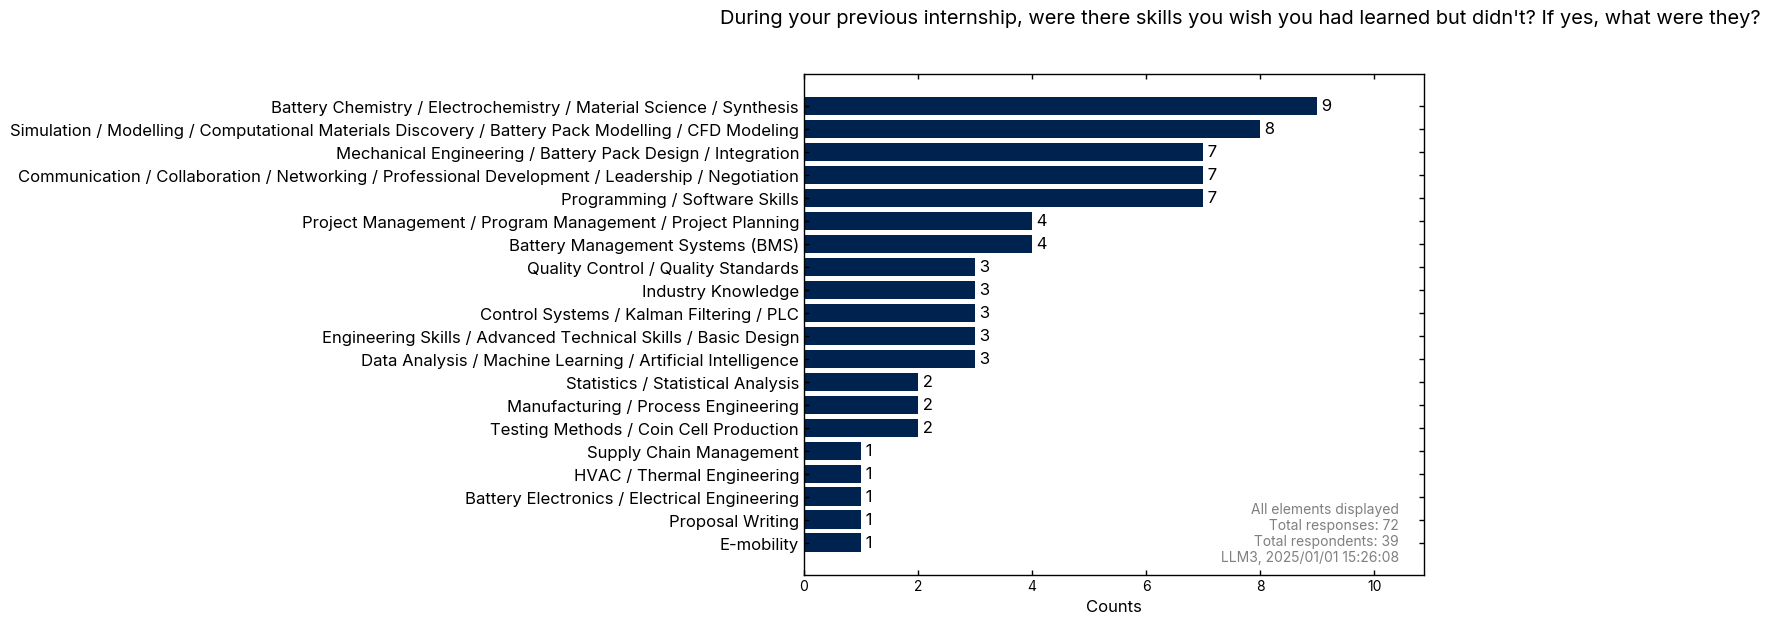

In [14]:
plotter.make_bar_plot_from_dict(counter,
                                title=question['question'],
                                sorted=True,
                                annotation=f'LLM3, {time.strftime("%Y/%m/%d %H:%M:%S")}',
                                num_elements=100,
                                saveas=f'{question['tag']}_{time.strftime("%Y%m%d_%H%M%S")}.png'
)